# Exercise 4
In this exercise, we will control a 2D drone depicted in the figure below <br>
<img src='quadrotor.png' width="300">

Consider the following simplified linear model of the drone
$$\begin{align}
    x_{n+1} = A
    x_n + B u_n
\end{align}$$

where the components of the state $x_n$ correspond to the horizontal position and velocity of the quadrotor, its vertical position and velocity and its orientation and angular velocity. The control vector
$u_n$ contains the forces produced by the rotors (our control inputs).
The module ```quadrotor.py``` defines the matrices $A$ and $B$ and code to generate a simulation of the drone.

In [1]:
## what we need to do computation and display the drone
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import quadrotor

In [2]:
# we define a few constants
xdim = 6 # dimension of the state (p,v)
udim = 2 # dimension of the control (u)
N = 500 # number of steps
nvars = N*udim + (N+1)*xdim # total number of variables
dt = 0.01 #delta t
sdim = xdim + udim # dimension of total state vector
## We define the cost
Q = np.eye(xdim)
Q[0,0] = Q[2,2] = Q[4,4] = 10.  # position penalty
Q[1,1] = Q[3,3] = Q[5,5] = 5.   # velocity penalty
R = np.eye(udim) * 0.01
des_state = np.array([3,0,3,0,0,0,0,0]).reshape(-1,1)


## we create G
def get_cost_matrix_G(Q, R):
    G = np.zeros((nvars, nvars))
    G[-xdim:, -xdim:] = Q
    mini_G = np.block([[Q, np.zeros((xdim, udim))], [np.zeros((udim, xdim)), R]])
    # Fill G blocks
    for i in np.arange(0, (xdim + udim)*N, (xdim+udim)):
        G[i:i+8, i:i+8] = mini_G
    return G

G = get_cost_matrix_G(Q,R)
print(G.shape)

(4006, 4006)


In [3]:
##### CREATE THE KKT SYSTEM #####
## create the linear equality constraint
M = np.zeros([xdim * (N+1), nvars])
d = np.zeros([xdim * (N+1)])
mini_M = np.block([[-np.eye(xdim), np.zeros((xdim, udim))], [quadrotor.A, quadrotor.B]])  # Define mini_M correctly
j = 0
for i in np.arange(0, 8*N, 8):
    M[j:(j+12), i:(i+8)] = mini_M  # Assign the mini_M block to M
    j += 6  # Increment by 6 for the next block
M[0:6, 0:6] = np.identity(6)
M[-6:, -6:] = -np.identity(6)

print(M.shape)

# Define p and ydes vectors
p = np.zeros((6 * (N + 1), 1))
ydes = np.block([[np.kron(np.ones((N, 1)), des_state)], [des_state[0:6]]])

# Compute G_des
G_des = np.matmul(G, ydes)

# Create the KKT matrix
nconstraints = M.shape[0]
nvars = G.shape[1]  # Assuming G has `nvars` columns
KKT = np.zeros((nvars + nconstraints, nvars + nconstraints))

# Fill the KKT matrix with appropriate blocks
KKT[0:nvars, 0:nvars] = G
KKT[nvars:, 0:nvars] = M
KKT[0:nvars, nvars:] = M.T

# Define the right-hand side vector (f)
f = np.zeros((nvars + nconstraints, 1))
f[0:nvars] = G_des  # Top part of f (matching `G_des`)
f[nvars:, 0] = p.flatten()  # Bottom part of f (matching `p`)

# Solve the KKT system
yl0 = np.linalg.solve(KKT, f)

(3006, 4006)


In [4]:
x_pos_0 = yl0[0:N*8+6:8].flatten()
x_vel_0 = yl0[1:N*8+6:8].flatten()
y_pos_0 = yl0[2:N*8+6:8].flatten()
y_vel_0 = yl0[3:N*8+6:8].flatten()
angle_0 = yl0[4:N*8+6:8].flatten()
angle_vel_0 = yl0[5:N*8+6:8].flatten()
control1_0 = yl0[6:N*8+6:8].flatten()
control2_0 = yl0[7:N*8+6:8].flatten()

# x0 = np.array([
#     x_pos_0,      # Shape: (501,)
#     x_vel_0,      # Shape: (501,)
#     y_pos_0,      # Shape: (501,)
#     y_vel_0,      # Shape: (501,)
#     angle_0,      # Shape: (501,)
#     angle_vel_0   # Shape: (501,)
# ])

# # print(f"x0 shape: {x0.shape}")  # Should output: (6, 501)

# u = np.vstack([
#     control1_0.flatten(),
#     control2_0.flatten()
# ])  # Shape: (2, 500)

# u = np.hstack([u, np.zeros((2, 1))])  # Shape: (2, 501)


(4006, 4006)
(4006, 1)
(8012, 4006)
(8012, 1)
(3006, 4006)
(3006, 1)


Text(0.5, 0, 'Time')

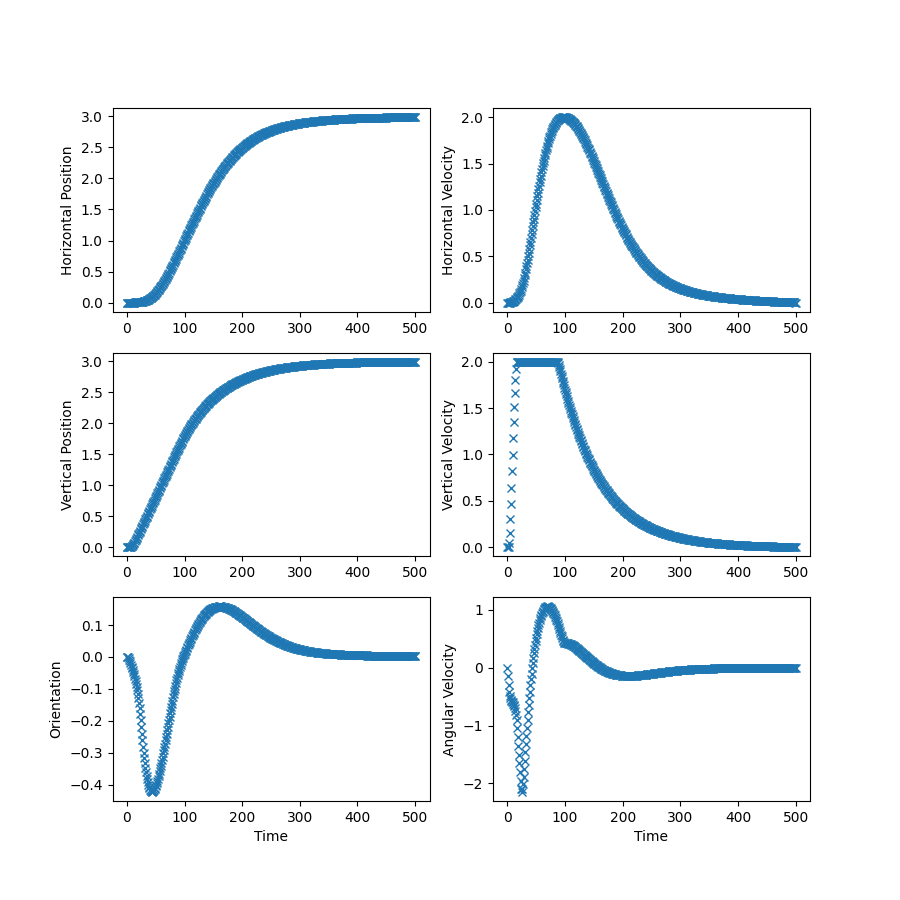

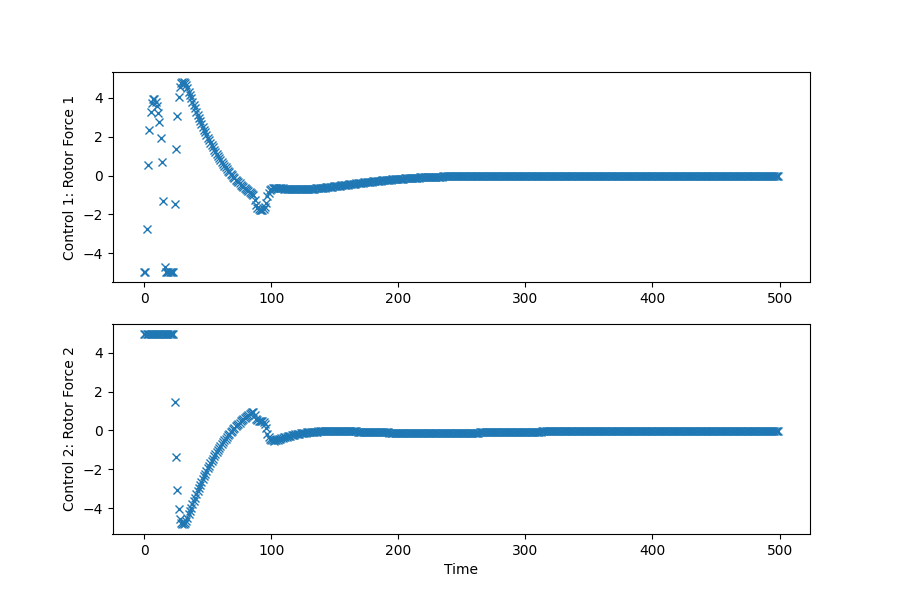

In [8]:
from qpsolvers import solve_qp
'''
H = np.zeros((nvars,nvars))
mini_H = np.zeros((8,8))
mini_H[1,1] = mini_H[3,3] = mini_H[6,6] = mini_H[7,7]= 1

H[-6:,-6:] = mini_H[0:6,0:6]
# Fill H blocks
for i in np.arange(0, (xdim + udim)*N, (xdim+udim)):
	H[i:i+8, i:i+8] = mini_H
# print(H[8:16,8:16])

max_lims = np.array([0, 2, 0, 2, 0, 0, 5, 5]).reshape(-1,1)

h = np.zeros((nvars,1))
h[-6:] = max_lims[0:6]
for i in np.arange(0, 8*N, 8):
	h[i:i+8] = max_lims
'''

max_lims = np.array([0, 2, 0, 2, 0, 0, 5, 5]).reshape(-1,1)
# For upper bounds 
H_upper = np.zeros((nvars, nvars))
mini_H = np.zeros((8, 8))
mini_H[1,1] = mini_H[3,3] = mini_H[6,6] = mini_H[7,7]= 1

H_upper[-6:, -6:] = mini_H[0:6, 0:6]
for i in np.arange(0, (xdim + udim) * N, (xdim + udim)):
    H_upper[i:i + 8, i:i + 8] = mini_H

h_upper = np.zeros((nvars, 1))
h_upper[-6:] = max_lims[0:6]
for i in np.arange(0, 8 * N, 8):
    h_upper[i:i + 8] = max_lims

# For lower bounds 
H_lower = np.zeros((nvars, nvars))
H_lower[-6:, -6:] = -mini_H[0:6, 0:6]
for i in np.arange(0, (xdim + udim) * N, (xdim + udim)):
    H_lower[i:i + 8, i:i + 8] = -mini_H

h_lower = np.zeros((nvars, 1))
h_lower[-6:] = max_lims[0:6]
for i in np.arange(0, 8 * N, 8):
    h_lower[i:i + 8] = max_lims

H = np.vstack((H_upper, H_lower))
h = np.vstack((h_upper, h_lower))

## Sanity Check for shapes
print(G.shape)
print(G_des.shape)
print(H.shape)
print(h.shape)
print(M.shape)
print(p.shape)
yl1 = solve_qp(G, -G_des, H, h, M, p, solver='cvxopt')


x_pos_1 = yl1[0:N*8+6:8].flatten()
x_vel_1 = yl1[1:N*8+6:8].flatten()
y_pos_1 = yl1[2:N*8+6:8].flatten()
y_vel_1 = yl1[3:N*8+6:8].flatten()
angle_1 = yl1[4:N*8+6:8].flatten()
angle_vel_1 = yl1[5:N*8+6:8].flatten()
control1_1 = yl1[6:N*8+6:8].flatten()
control2_1 = yl1[7:N*8+6:8].flatten()




plt.figure(figsize=[9,9])
plt.subplot(3,2,1)
plt.ylabel('Horizontal Position')
plt.plot(x_pos_1, 'x')
plt.subplot(3,2,2)
plt.ylabel('Horizontal Velocity')
plt.plot(x_vel_1, 'x')
plt.subplot(3,2,3)
plt.ylabel('Vertical Position')
plt.plot(y_pos_1, 'x')
plt.subplot(3,2,4)
plt.ylabel('Vertical Velocity')
plt.plot(y_vel_1, 'x')
plt.subplot(3,2,5)
plt.ylabel('Orientation')
plt.plot(angle_1, 'x')
plt.xlabel('Time')
plt.subplot(3,2,6)
plt.ylabel('Angular Velocity')
plt.plot(angle_vel_1, 'x')
plt.xlabel('Time')

plt.figure(figsize=[9,6])
plt.subplot(2,1,1)
plt.plot(control1_1, 'x')
plt.ylabel('Control 1: Rotor Force 1')
plt.subplot(2,1,2)
plt.plot(control2_1, 'x')
plt.ylabel('Control 2: Rotor Force 2')
plt.xlabel('Time')

# Animate the quadrotor using the computed state (x2) and control inputs (u2) with the desired goal position
# quadrotor.animate_robot(x2, u2, goal=[3, 3])

In [6]:
x_pos_1 = yl1[0:N*8+6:8].flatten()
x_vel_1 = yl1[1:N*8+6:8].flatten()
y_pos_1 = yl1[2:N*8+6:8].flatten()
y_vel_1 = yl1[3:N*8+6:8].flatten()
angle_1 = yl1[4:N*8+6:8].flatten()
angle_vel_1 = yl1[5:N*8+6:8].flatten()
control1_1 = yl1[6:N*8+6:8].flatten()
control2 = yl1[7:N*8+6:8].flatten()

x1 = np.array([
    x_pos_1,      # Shape: (501,)
    x_vel_1,      # Shape: (501,)
    y_pos_1,      # Shape: (501,)
    y_vel_1,      # Shape: (501,)
    angle_1,      # Shape: (501,)
    angle_vel_1   # Shape: (501,)
])

# print(f"x0 shape: {x0.shape}")  # Should output: (6, 501)

# u = np.vstack([
#     control1_1.flatten(),
#     control2_1.flatten()
# ])  # Shape: (2, 500)

# u = np.hstack([u, np.zeros((2, 1))])  # Shape: (2, 501)

# Animate the quadrotor 
quadrotor.animate_robot(x1, np.array([control1_1, control2_1]), goal=[3, 3])  

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMcRtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ETxliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCNT/0/deNpxANBL7R6l87LmplBSGUsMQgNinSvYBoi8EPlGhxil7rIakrntmRfU0qiM0BAfkrs+
j5GFt2itzqQrfd3lpmJFXa+MNDKxweBUJBLIU/3nnkAFuR+wSGS1R3baEJNmkJtv9QkKzPL1D8ge
RrUHH6iEMmPeZXqEU9N+wdZ3pbWsr3CmKqMPW6QAPuubbXHn7oeRPpcbdx2PEb3Pjv0LQIvWJTS6
Yshbxb/waOsmEtAuFYiPugmHD0Uc6dBSOZpxtrApYbKI8CPKIfy/TrX2bfrUpEhHQzbwirKEIlUT
NdITskVOP3ljXm345J8cPx/JrUJ1COOAsTYQkvg0Md8oYnS+vnP9lhYagjUv1VaxVIXy4l9q/R/5
lafLwxIIzF0i3TYnxR/GOVzx4f7YHyii4zCO4KkAvpx/Lhe/Nvsg0F9nL3dB4zxMhxfSnummKFF+
NbpCAX3ciQo1/xoMwW5dvBfgGSrmhfmP2TLsHX0My8Ps6CNW8oaBRsv2KAnL4k1HWSa/15EBV6/Y
yVeFyrPiObVuFOJX2OnvK2lC7UCJbZtWLMgXmMwbstRfe3zLE0OkbDULk5JxeTqi45j5esaybjZT
i4PsRQoaLh0I1MM0OnoZQ0iBq0BfU38JRO/gntoB7Ux1LOhJAmMDRx692xZkaYy4fcChajGjOlI0
mPWWECS4jAZ9jowyzzWYLV+a7Q5jNI+dIp8nmeXMh9xZDl5s7SZi9+G5VBg/dKqcVzzZ4kPCUtP+
gl9YAVmZr2i5wJ4NgRUWhtuvhdUkkOyehIcAV9vFmF5k9swg+9QNsSB5oc/Ubz0exOl3e2cASIvt
Rrbv06sNbngBEBfJJfP100p1FQKxpDr+hXWm3/L3p/9B6MEhbceUHT+3B4l3o0uwoQhhvzk5mu0F
i2oSwozj7vxkm0qcCvqQUaypUpMqbyinuvbHcD/6Wr3ilVdDsNOozmcAFqyL4cIBYsMHWhefUFmF
0m9iaCef2PYQEz0FQRtt7Nm18y3aaXIggNz2Yrm5+AAKdDJiI0B1opbK2ck9uc0mSz7KWNQCFIPS
7JQAAAbjm4/u1gAIQkNAzFKyEdhSz9ZUEhX4IfN9zhQoed8wO1J2ymrBKcIp1C2OFyzROoTASD6v
pFD1Hbe6IPYd9ERhW6/yxh33dXJIsFVrsMeaTGrEG2mUSwvgHF26bqay5GDdWeKbzPxDo+/5NzwT
GhXsbppzOOR3fqTviCpSJv1A9ftvbcQqnHslsdBNRKIvVaAhkFamix+wRn/2bmv7zKyB8NPqVzEt
WTaO7RgVJYdxdpPWneHWpVE5NVnPnKbFWrr5qW2jzKMMh/+p8c5uYZlzP3LC+pkc3W+Unq+MnOqT
lcYaTvetD2eZnxNUUCA/87gXjO1+OPN/qfTAHFGek4Kx5f/dcfS2SnJ0IxNgqkUp257GEr3HS3+X
nThxHyREMYHLFdwaL9dN6tuL/YTHtdZKJWIr6wJAgeHsiRE1UQTme/YoNVAVQvglDdLlsCy98umg
igmqCcwHfCHsT2lejdrMAAADAAADAFYSeTMt5sm17N7YaT24t7fTHMYO08IfHzNpGFSAnnYGJVhi
jlpOF5sLLdc9qgfrr39fFAaNZLM2ofbWse/L58M0Qaev8nDIcITxfXrnBS7I2LLZKRf+8xwBfWvp
qdiLKp4nr8y6O5R1oqpkypDGw/ibb+lexCkKr5LkTS2XC7QBmHAiv6lTBhfmBUjcea77Bi0JUNHD
y32evNFdi5hA1+Vh1haKoAWWQxt//ZmHmKNp6DFiMttG/6Areuhul91XJobFsbMmXcpUzT/5ncBW
9ChcmMjzGEkycrp5yY/lAlX3ay27R9u8eRFzocoIl/3PnzNcgOoSBBh6cH72AB+SG9P1pAAAjC7t
SlaDT8KYa4MpCzSJWA+DuDBfIu6eaBwh8d5jyJt5mfY1B2o6HY1fPp57UzSzDq6co/hINQ3lxkgr
q05BsClwcMZOBdtvVOVHmmlGQrrswJc3zGbYbHrygxGpaojlrbZ6ZQSoRD9V5a1oiPBCGPttq6a/
2eHguE2Pt0IVKHvfcctQIbckrn8PqVvtNYmVyXjIIkx3CwMVkPvgjn5nNxLQJ8itHy3T8545cL2y
x/VZJGb+I06pNyyytRF6xOgu6dZJlOeFf29rqBrKGQSwht0FemfO/JV4H+hOIU9jY7qQxffKNivp
kpaV//Ctw5PrJm//kX5jPDitKlrjoM1aSEqSvjb3TBIZ68ZlL5t3hKTY/ApHPmOgnBcsPHBvSX9v
kp6l8Md4uP8J2rAN10sXmKJD8mDZem7WRrwcleqYDwQTji+/LPYaEGfWxpfy6WCtzZC3M+gAuTKo
A8Jen5c5IFBg1FLU9C/rnIg7rO9N7/DEJbyMQ1jwH/pcxnegtnCRrbx5f5XQtiG3dVebwPTiWwmI
WingBvLn65y4pz7NLYEcMQjVjIYht3oJqARbSDvgdWh2BuRgiZlgW9q/eBkJFwz9xfj2yk1HaH7V
vA4xsKXpzvadpIRLGHQaotEMa5xGYjg+DMUxMnclqYtZZjQu/twFW/TWzTME5r4qMh3pV7BCNreX
wjtKwn8FlDKa26G5bo0NDvbJoGJvHou+R0KSejmAAP7uvMj8yG/oARfpywNbhwTU+SgEpIrfwI0i
ExVWFG2CG9qu80ydAt9JifBPMfDNK99WsWqM93r3VdWiu+y3mXoCMTnh+I1qepnXxr+fakFq5U21
VxNSq+yd0LtpZs8Fkd4Mqw+ndsbeNON2Q0VmoeWwoxdh70Ee5qijUvm/xfmFD9ynJU/7Sg1HlfRp
VucxpKHQItWEJHoSAzGUH

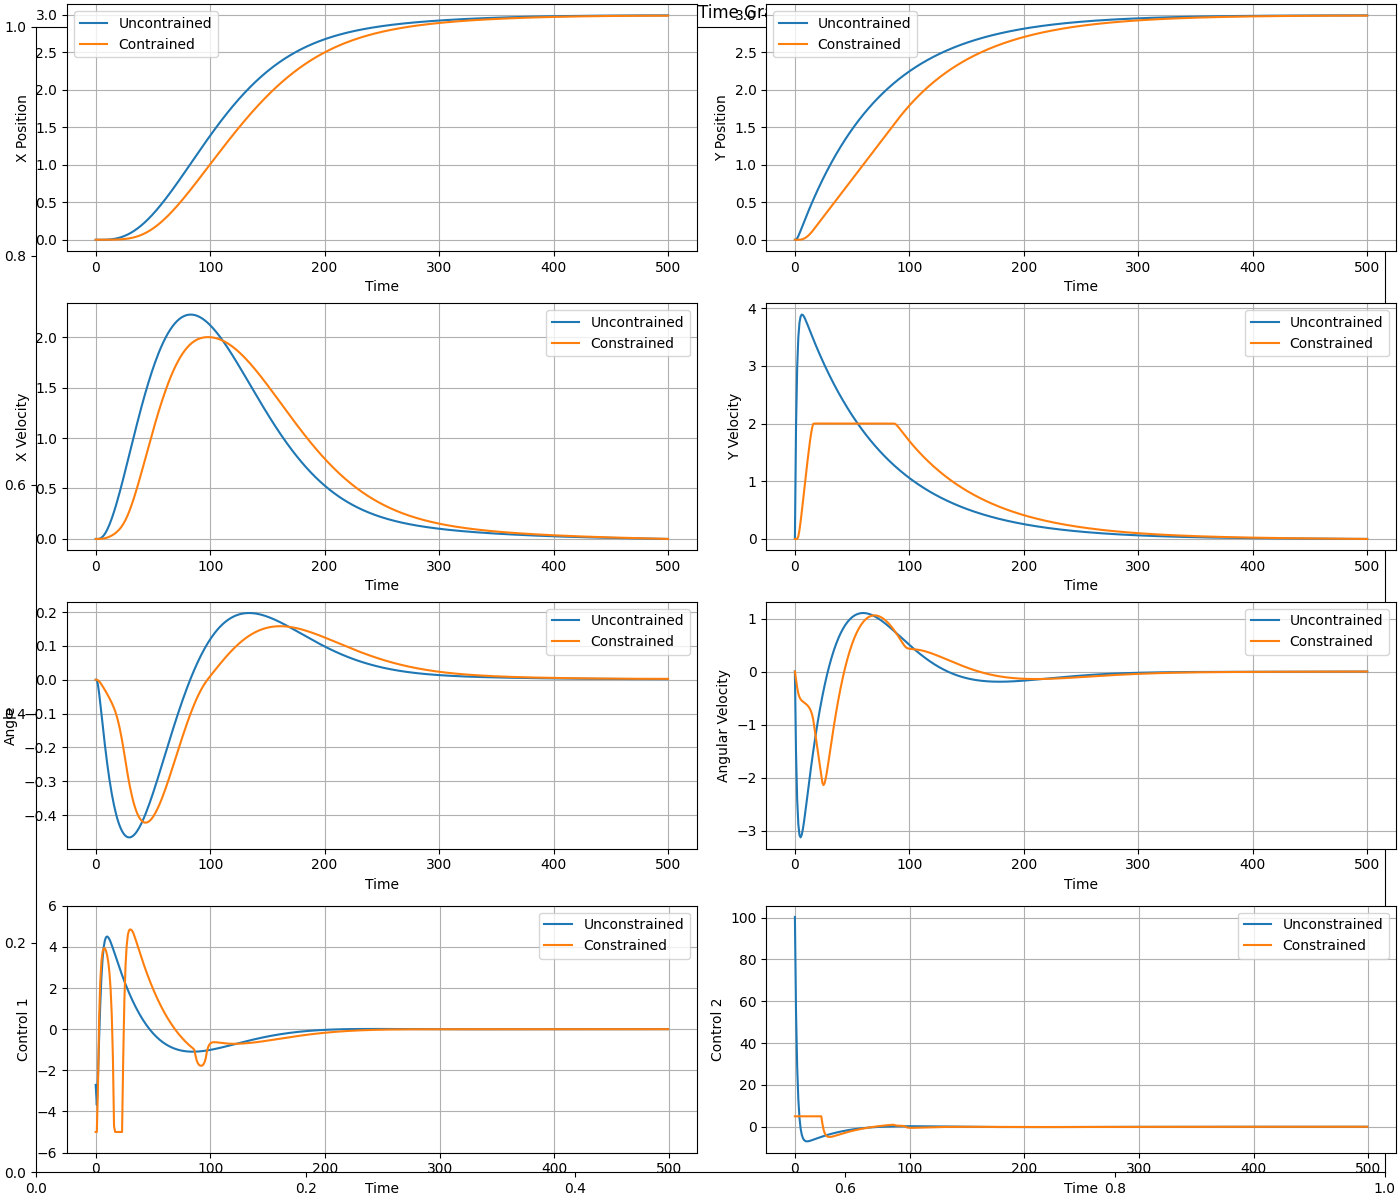

In [10]:
## Comparision of the Plots
plt.figure(figsize=[14,9], layout='constrained')
plt.subplot(4, 2, 1)
plt.plot(x_pos_0,label='Uncontrained')
plt.plot(x_pos_1,label='Contrained')
plt.ylabel('X Position')
plt.xlabel('Time')
plt.grid()
plt.legend()


plt.subplot(4, 2, 2)
plt.plot(y_pos_0,label='Uncontrained')
plt.plot(y_pos_1,label='Constrained')
plt.ylabel('Y Position')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(x_vel_0,label='Uncontrained')
plt.plot(x_vel_1,label='Constrained')
plt.ylabel('X Velocity')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(y_vel_0,label='Uncontrained')
plt.plot(y_vel_1,label='Constrained')
plt.ylabel('Y Velocity')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(angle_0,label='Uncontrained')
plt.plot(angle_1,label='Constrained')
plt.ylabel('Angle')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(angle_vel_0,label='Uncontrained')
plt.plot(angle_vel_1,label='Constrained')
plt.ylabel('Angular Velocity')
plt.xlabel('Time')
plt.grid()
plt.legend()


plt.subplot(4,2,7)
plt.plot(control1_0, label='Unconstrained')
plt.plot(control1_1, label='Constrained')
plt.ylabel('Control 1')
plt.xlabel('Time')
plt.ylim(-6,6)
plt.grid()
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(control2_0, label='Unconstrained')
plt.plot(control2_1, label='Constrained')
plt.ylabel('Control 2')
plt.xlabel('Time')
plt.grid()
plt.legend()


## Results and Observations
- The unconstrained model ramps up fast and converges just a bit faster than the constrained model
- Control 2 in the unconstrained model is over feasible physical limits which proves the necessities of having constraints on control input so as to avoid the results from exploding 
- The model above has been tested in desired coordinates in all 4 quadrants with the same eucilidian distance to test the negative constraints

### References
- Lecture Example 2 - LQ Problems with KKT and QP [Link](https://github.com/righetti/optlearningcontrol/blob/main/Examples/Lecture%202%20-%20LQ%20problems%20with%20KKT%20and%20QP.ipynb)